# Project NLP G1

This project contains 2 datasets:
- Label 0: Fake News
- Label 1: Real News

Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import twitter_samples    # sample Twitter dataset from NLTK
import matplotlib.pyplot as plt            # library for visualization
import random                              # pseudo-random number generato

Load the DataSet

In [2]:
file_path = 'training_data_lowercase.csv'
dataset = pd.read_csv(file_path, delimiter='\t', header=None, names=["Tag", "Sentence"])

print(dataset['Sentence'].dtype)
print(dataset['Sentence'].head())


object
0    donald trump sends out embarrassing new year‚s...
1    drunk bragging trump staffer started russian c...
2    sheriff david clarke becomes an internet joke ...
3    trump is so obsessed he even has obama‚s name ...
4    pope francis just called out donald trump duri...
Name: Sentence, dtype: object


## Data Exploration

Understanding the Structure of the Dataset

In [3]:
dataset.info()
dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34152 entries, 0 to 34151
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Tag       34152 non-null  int64 
 1   Sentence  34152 non-null  object
dtypes: int64(1), object(1)
memory usage: 533.8+ KB


,Tag,Sentence
0,0,donald trump sends out embarrassing new year‚s...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes an internet joke ...
3,0,trump is so obsessed he even has obama‚s name ...
4,0,pope francis just called out donald trump duri...


3) Checking the Class distribution
###### Here we are just counting how many sentences are translated by the machine and how many are translated by a professional

In [4]:
class_distribution = dataset['Tag'].value_counts()
print(class_distribution)

Tag
0    17572
1    16580
Name: count, dtype: int64


4) Analyzing Sentence Lenght
- We add a column to the dataset that calculates the lenght of each sentence
- we look at the summary statisticss for sentence lenght

In [5]:
dataset['Sentence_Length'] = dataset['Sentence'].apply(len)


In [6]:
sentence_length_stats = dataset['Sentence_Length'].describe()
print(sentence_length_stats)

count    34152.000000
mean        74.680839
std         23.460862
min          2.000000
25%         61.000000
50%         70.000000
75%         85.000000
max        279.000000
Name: Sentence_Length, dtype: float64


5) Visualizing the Data

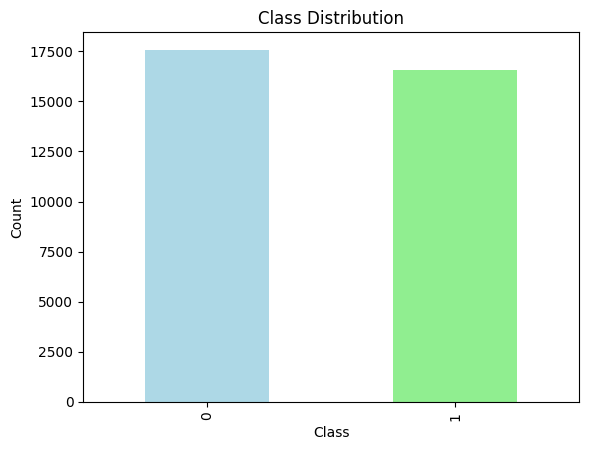

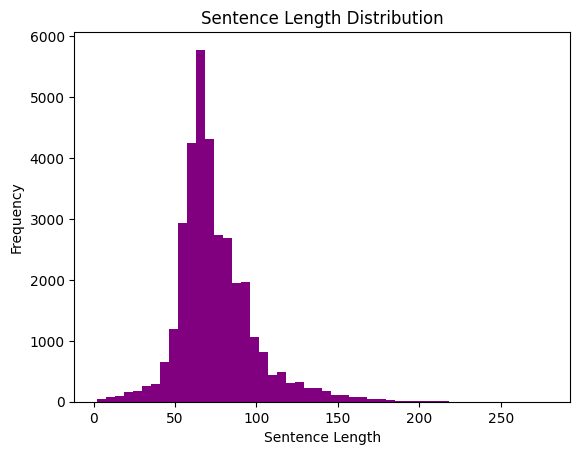

In [7]:
import matplotlib.pyplot as plt

# Class Distribution
dataset['Tag'].value_counts().plot(kind='bar', title="Class Distribution", color=['lightblue', 'lightgreen'])
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# Sentence Length Distribution
dataset['Sentence_Length'].plot(kind='hist', bins=50, title="Sentence Length Distribution", color='purple')
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.show()

## Text Processing

In [8]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

1) Tokenization and Normalization (removing punctuation)

In [9]:

# Step 1: Tokenization and Normalization (lowercasing and removing punctuation)
def preprocess_text(text):

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    return tokens




2) Applying the Preprocessing Function

In [10]:
dataset['Tokenized_Sentence'] = dataset['Sentence'].apply(preprocess_text)


3) Lemmatization

In [11]:

lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

dataset['Lemmatized_Sentence'] = dataset['Tokenized_Sentence'].apply(lemmatize_tokens)

dataset.head()



,Tag,Sentence,Sentence_Length,Tokenized_Sentence,Lemmatized_Sentence
0,0,donald trump sends out embarrassing new year‚s...,78,"[donald, trump, sends, out, embarrassing, new,...","[donald, trump, sends, out, embarrassing, new,..."
1,0,drunk bragging trump staffer started russian c...,68,"[drunk, bragging, trump, staffer, started, rus...","[drunk, bragging, trump, staffer, started, rus..."
2,0,sheriff david clarke becomes an internet joke ...,89,"[sheriff, david, clarke, becomes, an, internet...","[sheriff, david, clarke, becomes, an, internet..."
3,0,trump is so obsessed he even has obama‚s name ...,77,"[trump, is, so, obsessed, he, even, has, obama...","[trump, is, so, obsessed, he, even, ha, obamas..."
4,0,pope francis just called out donald trump duri...,69,"[pope, francis, just, called, out, donald, tru...","[pope, francis, just, called, out, donald, tru..."


In [12]:
!pip install textblob

## Feature Extraction

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from textblob import TextBlob
from scipy.sparse import hstack

# Apply TextBlob sentiment analysis
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Create a new 'Sentiment' column based on sentiment polarity
dataset['Sentiment'] = dataset['Sentence'].apply(get_sentiment)

# Shift sentiment values from [-1, 1] to [0, 2]
dataset['Sentiment'] = dataset['Sentiment'] + 1

# Step 1: Feature extraction using TfidfVectorizer
tfidf_vect = TfidfVectorizer()
X_tfidf = tfidf_vect.fit_transform(dataset['Lemmatized_Sentence'].apply(lambda x: ' '.join(x)))

# Step 2: Feature extraction using CountVectorizer
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(dataset['Lemmatized_Sentence'].apply(lambda x: ' '.join(x)))

# Combine TF-IDF features with shifted sentiment polarity for TF-IDF
sentiment_feature_tfidf = dataset['Sentiment'].values.reshape(-1, 1)
X_combined_tfidf = hstack([X_tfidf, sentiment_feature_tfidf])

# Combine CountVectorizer features with shifted sentiment polarity for CountVectorizer
sentiment_feature_count = dataset['Sentiment'].values.reshape(-1, 1)
X_combined_count = hstack([X_counts, sentiment_feature_count])

# Now you can proceed with Naive Bayes and Random Forest using both feature sets

# Labels (Target variable)
y = dataset['Tag']  # Assuming the column name is 'Tag'


## Model Architecture

In [14]:


# Split

X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_combined_tfidf, y, test_size=0.2, random_state=42)
X_train_count, X_test_count, y_train, y_test = train_test_split(X_combined_count, y, test_size=0.2, random_state=42)

# Define both models
models_tfidf = {
    "Naive Bayes (TF-IDF)": MultinomialNB(),
    "Random Forest (TF-IDF)": RandomForestClassifier(n_estimators=100, random_state=42)
}

models_count = {
    "Naive Bayes (CountVectorizer)": MultinomialNB(),
    "Random Forest (CountVectorizer)": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Train and evaluate both models with TF-IDF
print("Evaluating models with TF-IDF features...\n")
for model_name, model in models_tfidf.items():
    # Train the model
    model.fit(X_train_tfidf, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_tfidf)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Classifier Accuracy: {accuracy}")
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print("\n" + "="*60 + "\n")

# Train and evaluate both models with CountVectorizer
print("Evaluating models with CountVectorizer features...\n")
for model_name, model in models_count.items():
    # Train the model
    model.fit(X_train_count, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_count)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Classifier Accuracy: {accuracy}")
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print("\n" + "="*60 + "\n")


Evaluating models with TF-IDF features...

Naive Bayes (TF-IDF) Classifier Accuracy: 0.937637241985068
Naive Bayes (TF-IDF) Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      3529
           1       0.94      0.93      0.94      3302

    accuracy                           0.94      6831
   macro avg       0.94      0.94      0.94      6831
weighted avg       0.94      0.94      0.94      6831



Random Forest (TF-IDF) Classifier Accuracy: 0.9352949787732396
Random Forest (TF-IDF) Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      3529
           1       0.93      0.94      0.93      3302

    accuracy                           0.94      6831
   macro avg       0.94      0.94      0.94      6831
weighted avg       0.94      0.94      0.94      6831



Evaluating models with CountVectorizer features...

Naive Bayes (CountVectorizer) Clas

Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, classification_report

# Define the scoring metric
scoring = 'accuracy'

# Perform cross-validation for models with TF-IDF
print("Cross-validation for models with TF-IDF features...\n")
for model_name, model in models_tfidf.items():
    print(f"Cross-validating {model_name}...")
    
    # Perform cross-validation
    scores = cross_val_score(model, X_combined_tfidf, y, cv=5, scoring=scoring)
    
    # Print the cross-validation results
    print(f"{model_name} 5-Fold Cross-Validation Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})\n")
    
# Perform cross-validation for models with CountVectorizer
print("Cross-validation for models with CountVectorizer features...\n")
for model_name, model in models_count.items():
    print(f"Cross-validating {model_name}...")
    
    # Perform cross-validation
    scores = cross_val_score(model, X_combined_count, y, cv=5, scoring=scoring)
    
    # Print the cross-validation results
    print(f"{model_name} 5-Fold Cross-Validation Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})\n")


Cross-validation for models with TF-IDF features...

Cross-validating Naive Bayes (TF-IDF)...
Naive Bayes (TF-IDF) 5-Fold Cross-Validation Accuracy: 0.9105 (+/- 0.0219)

Cross-validating Random Forest (TF-IDF)...
Random Forest (TF-IDF) 5-Fold Cross-Validation Accuracy: 0.9051 (+/- 0.0193)

Cross-validation for models with CountVectorizer features...

Cross-validating Naive Bayes (CountVectorizer)...
Naive Bayes (CountVectorizer) 5-Fold Cross-Validation Accuracy: 0.9170 (+/- 0.0220)

Cross-validating Random Forest (CountVectorizer)...
Random Forest (CountVectorizer) 5-Fold Cross-Validation Accuracy: 0.8974 (+/- 0.0256)



## Plotting results

Train and Test Accuracy

Training Naive Bayes (TF-IDF)...
Naive Bayes (TF-IDF) Training Accuracy: 0.9530
Naive Bayes (TF-IDF) Validation Accuracy: 0.9329
Naive Bayes (TF-IDF) Test Accuracy: 0.9423
Training Random Forest (TF-IDF)...
Random Forest (TF-IDF) Training Accuracy: 1.0000
Random Forest (TF-IDF) Validation Accuracy: 0.9356
Random Forest (TF-IDF) Test Accuracy: 0.9350
Training Naive Bayes (CountVectorizer)...
Naive Bayes (CountVectorizer) Training Accuracy: 0.9544
Naive Bayes (CountVectorizer) Validation Accuracy: 0.9344
Naive Bayes (CountVectorizer) Test Accuracy: 0.9473
Training Random Forest (CountVectorizer)...
Random Forest (CountVectorizer) Training Accuracy: 1.0000
Random Forest (CountVectorizer) Validation Accuracy: 0.9277
Random Forest (CountVectorizer) Test Accuracy: 0.9350


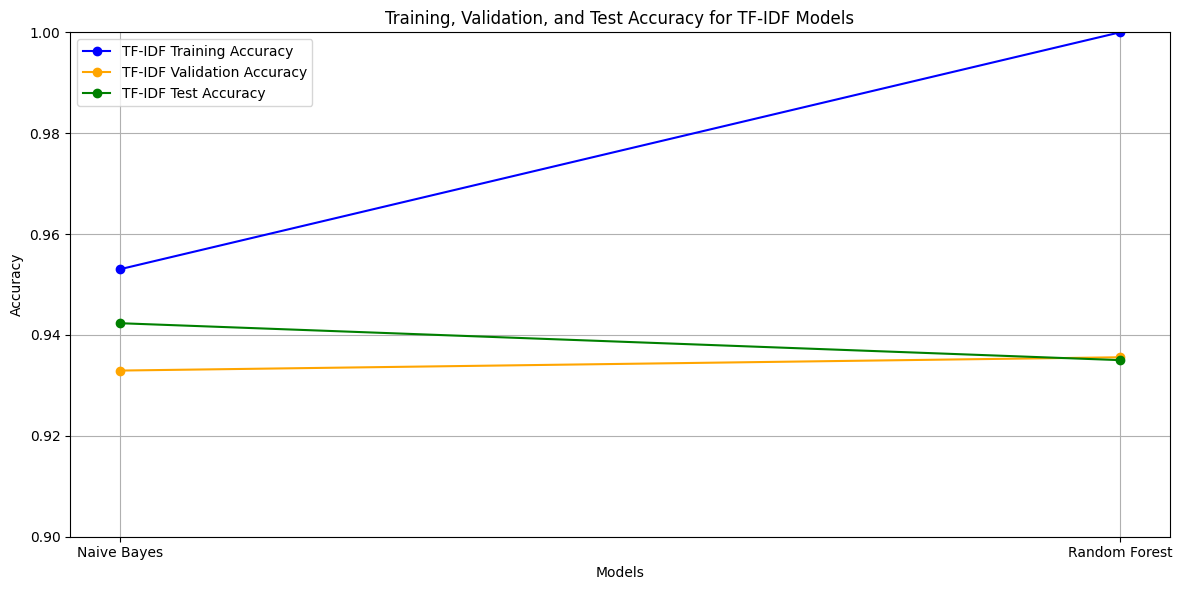

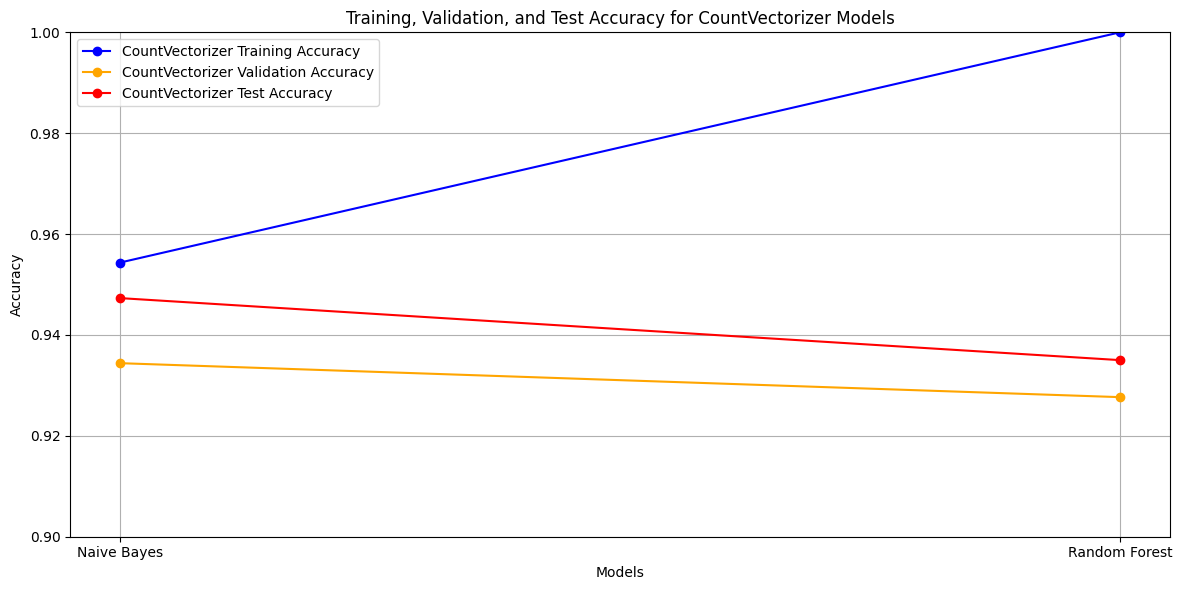

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Initialize lists to store training, validation, and test accuracies for TF-IDF and CountVectorizer
training_accuracies_tfidf = []
validation_accuracies_tfidf = []
test_accuracies_tfidf = []

training_accuracies_count = []
validation_accuracies_count = []
test_accuracies_count = []

# First, split the data into training+validation and test sets (80% train+val, 20% test)
X_train_tfidf, X_temp_tfidf, y_train, y_temp = train_test_split(X_combined_tfidf, y, test_size=0.2, random_state=42)
X_train_count, X_temp_count, y_train, y_temp = train_test_split(X_combined_count, y, test_size=0.2, random_state=42)

# Then, split the temp set into validation and test sets (50% validation, 50% test from the temp set)
X_val_tfidf, X_test_tfidf, y_val, y_test = train_test_split(X_temp_tfidf, y_temp, test_size=0.5, random_state=42)
X_val_count, X_test_count, y_val_count, y_test_count = train_test_split(X_temp_count, y_temp, test_size=0.5, random_state=42)

# Train and evaluate both models with TF-IDF
for model_name, model in models_tfidf.items():
    print(f"Training {model_name}...")
    model.fit(X_train_tfidf, y_train)

    # Make predictions on training, validation, and test data
    y_pred_train_tfidf = model.predict(X_train_tfidf)
    y_pred_val_tfidf = model.predict(X_val_tfidf)
    y_pred_test_tfidf = model.predict(X_test_tfidf)

    # Evaluate the model
    train_accuracy = accuracy_score(y_train, y_pred_train_tfidf)  # Training accuracy
    val_accuracy = accuracy_score(y_val, y_pred_val_tfidf)  # Validation accuracy
    test_accuracy = accuracy_score(y_test, y_pred_test_tfidf)  # Test accuracy

    training_accuracies_tfidf.append(train_accuracy)
    validation_accuracies_tfidf.append(val_accuracy)
    test_accuracies_tfidf.append(test_accuracy)

    print(f"{model_name} Training Accuracy: {train_accuracy:.4f}")
    print(f"{model_name} Validation Accuracy: {val_accuracy:.4f}")
    print(f"{model_name} Test Accuracy: {test_accuracy:.4f}")

# Train and evaluate both models with CountVectorizer
for model_name, model in models_count.items():
    print(f"Training {model_name}...")
    model.fit(X_train_count, y_train)

    # Make predictions on training, validation, and test data
    y_pred_train_count = model.predict(X_train_count)
    y_pred_val_count = model.predict(X_val_count)
    y_pred_test_count = model.predict(X_test_count)

    # Evaluate the model
    train_accuracy = accuracy_score(y_train, y_pred_train_count)  # Training accuracy
    val_accuracy = accuracy_score(y_val_count, y_pred_val_count)  # Validation accuracy
    test_accuracy = accuracy_score(y_test_count, y_pred_test_count)  # Test accuracy

    training_accuracies_count.append(train_accuracy)
    validation_accuracies_count.append(val_accuracy)
    test_accuracies_count.append(test_accuracy)

    print(f"{model_name} Training Accuracy: {train_accuracy:.4f}")
    print(f"{model_name} Validation Accuracy: {val_accuracy:.4f}")
    print(f"{model_name} Test Accuracy: {test_accuracy:.4f}")

# Define the labels for the models
models = ['Naive Bayes', 'Random Forest']

# Plot for TF-IDF
plt.figure(figsize=(12, 6))
plt.plot(models, training_accuracies_tfidf, label='TF-IDF Training Accuracy', marker='o', color='blue')
plt.plot(models, validation_accuracies_tfidf, label='TF-IDF Validation Accuracy', marker='o', color='orange')
plt.plot(models, test_accuracies_tfidf, label='TF-IDF Test Accuracy', marker='o', color='green')

# Set y-axis limits to "zoom in"
plt.ylim(0.90, 1.0)  # Adjust based on your accuracy values

# Add titles and labels
plt.title('Training, Validation, and Test Accuracy for TF-IDF Models')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

# Plot for CountVectorizer
plt.figure(figsize=(12, 6))
plt.plot(models, training_accuracies_count, label='CountVectorizer Training Accuracy', marker='o', color='blue')
plt.plot(models, validation_accuracies_count, label='CountVectorizer Validation Accuracy', marker='o', color='orange')
plt.plot(models, test_accuracies_count, label='CountVectorizer Test Accuracy', marker='o', color='red')

# Set y-axis limits to "zoom in"
plt.ylim(0.90, 1.0)  # Adjust based on your accuracy values

# Add titles and labels
plt.title('Training, Validation, and Test Accuracy for CountVectorizer Models')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()



Model Performance

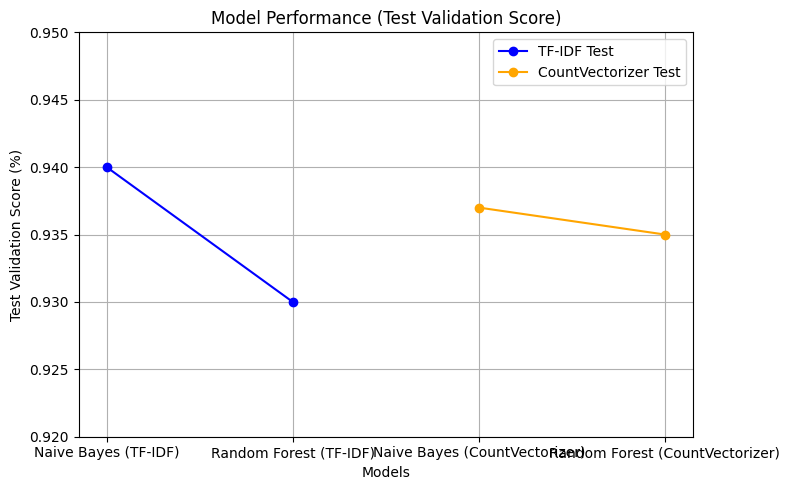

In [16]:
import matplotlib.pyplot as plt

# Data for the plot (replace these with your actual test scores)
models = ['Naive Bayes (TF-IDF)', 'Random Forest (TF-IDF)', 'Naive Bayes (CountVectorizer)', 'Random Forest (CountVectorizer)']
test_scores_tfidf = [0.94, 0.93]  # Example test scores for TF-IDF models
test_scores_countvectorizer = [0.937, 0.935]  # Example test scores for CountVectorizer models

# Combine both sets of scores into one for plotting
test_scores = test_scores_tfidf + test_scores_countvectorizer

# Plot the results
plt.figure(figsize=(8, 5))

# Line plot for TF-IDF test scores
plt.plot(models[:2], test_scores_tfidf, label='TF-IDF Test', marker='o', color='blue')

# Line plot for CountVectorizer test scores
plt.plot(models[2:], test_scores_countvectorizer, label='CountVectorizer Test', marker='o', color='orange')

# Add title and labels
plt.title('Model Performance (Test Validation Score)')
plt.xlabel('Models')
plt.ylabel('Test Validation Score (%)')
plt.ylim(0.92, 0.95)  # Adjust this based on your result range

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()
